In [ ]:
import cv2,os
import numpy as np
from keras.utils import np_utils
data_path='/content/drive/MyDrive/Face Mask Detector/dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:',e)
            

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],100, 100,1))
target=np.array(target)



new_target=np_utils.to_categorical(target)

np.save('/content/drive/MyDrive/Maskdata',data)
np.save('/content/drive/MyDrive/target',new_target)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

data=np.load('/content/drive/MyDrive/Maskdata.npy')
target=np.load('/content/drive/MyDrive/target.npy')

model=Sequential()

model.add(Conv2D(100,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

checkpoint = ModelCheckpoint(
  '/content/drive/MyDrive/Mask Detection Models/model.model',
  monitor='val_loss',
  verbose=0,
  save_best_only=True,
  mode='auto')

history=model.fit(
  train_data,
  train_target,
  epochs=20,
  callbacks=[checkpoint],
  validation_split=0.2)

print(model.evaluate(test_data,test_target))

Epoch 1/20
31/31 [==============================] - 2s 40ms/step - loss: 0.7998 - accuracy: 0.4987 - val_loss: 0.6632 - val_accuracy: 0.5887
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mask Detection Models/model.model/assets
Epoch 2/20
31/31 [==============================] - 1s 28ms/step - loss: 0.6370 - accuracy: 0.6270 - val_loss: 0.5198 - val_accuracy: 0.7621
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mask Detection Models/model.model/assets
Epoch 3/20
31/31 [==============================] - 1s 28ms/step - loss: 0.4449 - accuracy: 0.8041 - val_loss: 0.3638 - val_accuracy: 0.8548
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mask Detection Models/model.model/assets
Epoch 4/20
31/31 [==============================] - 1s 28ms/step - loss: 0.3023 - accuracy: 0.8785 - val_loss: 0.2610 - val_accuracy: 0.9073
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mask Detection Models/model.model/assets
Epoch 5/20
31/31 [======================

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  labels_dict={0:'with_mask',1:'without_mask'}
  color_dict={0:(0,255,0),1:(0,0,255)}
  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_clsfr.detectMultiScale(gray,1.3,5)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
    print('1')
    face_img=gray[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(100,100))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,100,100,1))
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]
    img = cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    img = cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    img = cv2.putText(
          img, labels_dict[label], 
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Mask Detection Models/model.model')
face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

<IPython.core.display.Javascript object>

(480, 640)
1
Saved to photo.jpg


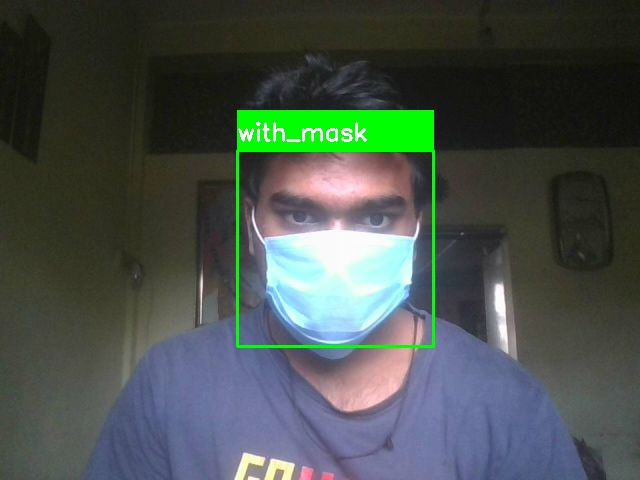

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_clsfr.detectMultiScale(gray , 1.3 ,5)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      face_img=gray[y:y+w,x:x+w]
      resized=cv2.resize(face_img,(100,100))
      normalized=resized/255.0
      reshaped=np.reshape(normalized,(1,100,100,1))
      result=model.predict(reshaped)
      label=np.argmax(result,axis=1)[0]
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),color_dict[label],2)
      bbox_array = cv2.rectangle(bbox_array,(x,y-40),(x+w,y),color_dict[label],-1)
      bbox_array = cv2.putText(
            bbox_array, labels_dict[label], 
            (x, y-10),
            cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('model-011.model')
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(
          img, labels_dict[label], 
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

OSError: ignored